In [1]:
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
EXPERIMENT_NAME = "BipedalWalkerHardcore-PPO"
LOG_PATH = f"/app/rl_agents/logs/{EXPERIMENT_NAME}/app.log"
REFRESH_SEC = 2
SMOOTH_WINDOW = 20

In [3]:
episode_pattern = re.compile(
    r"mean reward: (?P<reward>-?\d+\.\d+), mean length: (?P<length>\d+\.\d+)"
)

loss_pattern = re.compile(
    r"policy_loss (?P<policy>-?\d+\.\d+)\s+"
    r"critic_loss (?P<critic>-?\d+\.\d+)\s+"
    r"entropy (?P<entropy>\d+\.\d+)\s+"
    r"loss (?P<total>-?\d+\.\d+)"
)

In [4]:
def read_logs():
    rewards, lengths = [], []
    policy, critic, entropy, total = [], [], [], []

    with open(LOG_PATH, "r") as f:
        for line in f:
            m = episode_pattern.search(line)
            if m:
                rewards.append(float(m.group("reward")))
                lengths.append(float(m.group("length")))

            m = loss_pattern.search(line)
            if m:
                policy.append(float(m.group("policy")))
                critic.append(float(m.group("critic")))
                entropy.append(float(m.group("entropy")))
                total.append(float(m.group("total")))

    return (
        pd.DataFrame({"reward": rewards, "length": lengths}),
        pd.DataFrame({
            "policy": policy,
            "critic": critic,
            "entropy": entropy,
            "total": total,
        })
    )

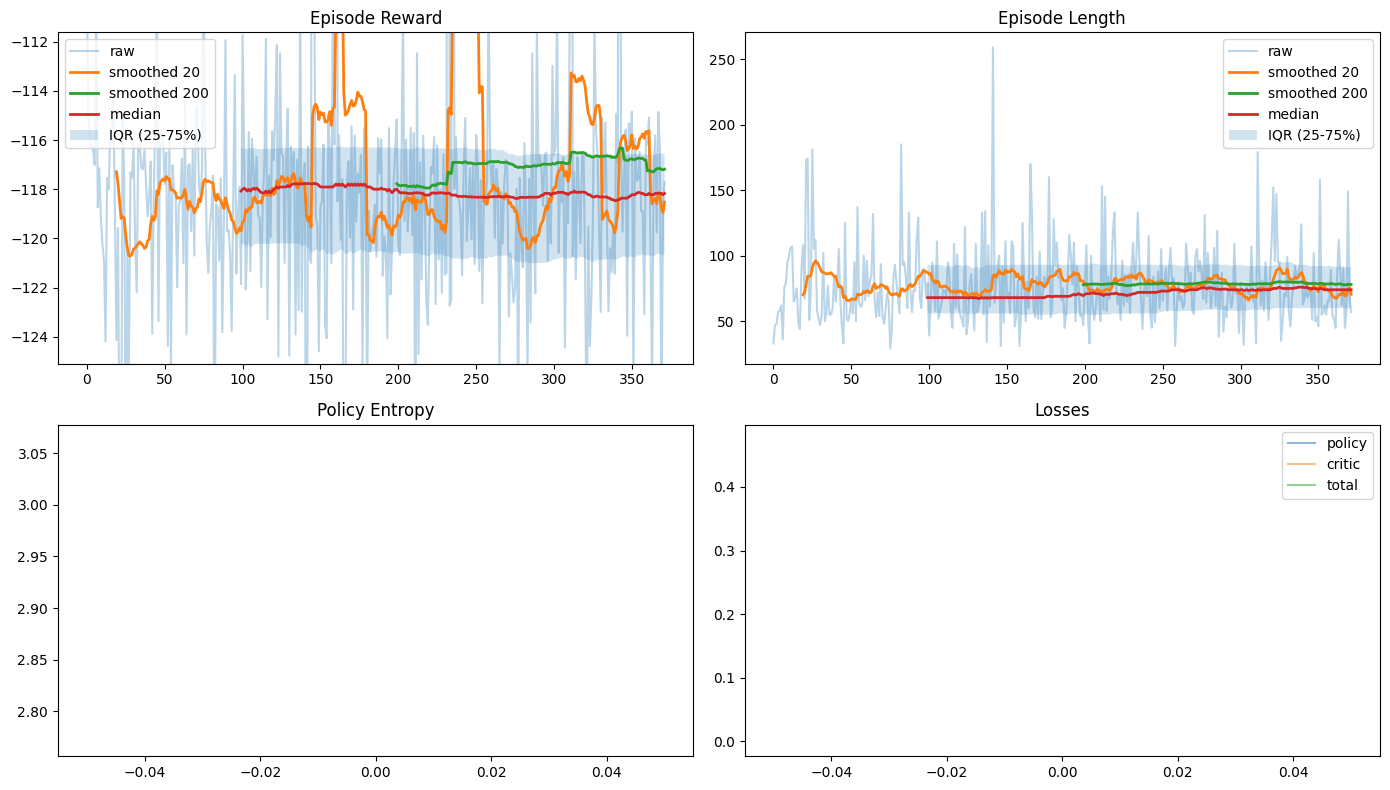

In [ ]:
plt.ion()

while True:
    try:
        df_ep, df_loss = read_logs()
    except FileNotFoundError:
        time.sleep(REFRESH_SEC)
        continue

    clear_output(wait=True)

    fig, ax = plt.subplots(2, 2, figsize=(14, 8))

    # --- Episode reward ---
    if len(df_ep):
        ax[0, 0].plot(df_ep["reward"], alpha=0.3, label="raw")
        ax[0, 0].plot(df_ep["reward"].rolling(SMOOTH_WINDOW).mean(), linewidth=2, label=f"smoothed {SMOOTH_WINDOW}")
        ax[0, 0].plot(df_ep["reward"].rolling(SMOOTH_WINDOW*10).mean(), linewidth=2, label=f"smoothed {SMOOTH_WINDOW*10}")
        window = SMOOTH_WINDOW * 10
        rolling = df_ep["reward"].rolling(window, min_periods=window // 2)

        median = rolling.median()
        q25 = rolling.quantile(0.25)
        q75 = rolling.quantile(0.75)

        ax[0, 0].plot(median, linewidth=2, label="median", )
        ax[0, 0].fill_between(
            q25.index,
            q25,
            q75,
            alpha=0.2,
            label="IQR (25-75%)"
        )
        high = df_ep["reward"].quantile(0.95)
        low = df_ep["reward"].quantile(0.05)
        diff = high - low
        ax[0, 0].set_ylim(low - (high - low) * 0.01, high + (high - low) * 0.01)
        ax[0, 0].set_title("Episode Reward")
        ax[0, 0].legend()

        ax[0, 1].plot(df_ep["length"], alpha=0.3, label="raw")
        ax[0, 1].plot(df_ep["length"].rolling(SMOOTH_WINDOW).mean(), linewidth=2, label=f"smoothed {SMOOTH_WINDOW}")
        ax[0, 1].plot(df_ep["length"].rolling(SMOOTH_WINDOW*10).mean(), linewidth=2, label=f"smoothed {SMOOTH_WINDOW*10}")
        window = SMOOTH_WINDOW * 10
        rolling = df_ep["length"].rolling(window, min_periods=window // 2)

        median = rolling.median()
        q25 = rolling.quantile(0.25)
        q75 = rolling.quantile(0.75)

        ax[0, 1].plot(median, linewidth=2, label="median")
        ax[0, 1].fill_between(
            q25.index,
            q25,
            q75,
            alpha=0.2,
            label="IQR (25-75%)"
        )
        ax[0, 1].set_title("Episode Length")
        ax[0, 1].legend()

    # --- Entropy ---
    if len(df_loss):
        ax[1, 0].plot(df_loss["entropy"], alpha=0.3)
        ax[1, 0].set_title("Policy Entropy")

        # --- Losses ---
        ax[1, 1].plot(df_loss["policy"], label="policy", alpha=0.5)
        ax[1, 1].plot(df_loss["critic"], label="critic", alpha=0.5)
        ax[1, 1].plot(df_loss["total"], label="total", alpha=0.5)
        ax[1, 1].legend()
        ax[1, 1].set_title("Losses")

    plt.tight_layout()
    plt.show()

    time.sleep(REFRESH_SEC)
